# Chapter 2 of PhD thesis

This notebook contains code used to generate images from Chapter 2 of my PhD thesis, which presents a general overview of machine learning concepts

Where data downloads are required, information on data access is given as a heading above each cell

In [28]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle
from scipy import stats
import os
from netCDF4 import Dataset
from scipy.interpolate import griddata
from scipy.spatial.distance import squareform,pdist,cdist
from numpy.linalg import multi_dot as mdot
import seaborn as sns
import networkx as mx

%matplotlib inline

#setup LaTeX style font 
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsfonts}",r"\usepackage{amsmath}"]
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 20

def cmap_discretize(cmap, N): 
    """Return a discrete colormap from the continuous colormap cmap.    
    cmap: colormap instance, eg. cm.jet.  
    N: number of colors.    
    Example
    x = resize(arange(100), (5,100))
    djet = cmap_discretize(cm.jet, 5)
    imshow(x, cmap=djet)
    """
    if type(cmap) == str:
        cmap = mpl.cm.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(1./N*0.5, 1-(1./N*0.5), N), (0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1) ]
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def draw_meridians(m, ax, hemisphere, width_percent=0.03, degree=30, meridians=False, fontsize=20):
    """
    Add circular meridians around Basemap image when using round=True call
    """
    from matplotlib.patches import Wedge
    centre_x = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
    centre_y = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
    width = abs(centre_x) * width_percent

    inner_radius = (abs(centre_x) - width/2) + 4e4
    outer_radius = inner_radius + width

    angle_breaks = list(range(0, 361, degree))

    for i, (from_angle, to_angle) in enumerate(list(zip(angle_breaks[:-1], angle_breaks[1:]))):
        color='white' if i%2 == 0 else 'black'
        wedge = Wedge((centre_x, centre_y), outer_radius, from_angle, to_angle, width=outer_radius - inner_radius, 
                      facecolor=color,
                      edgecolor='black',
                      clip_on=False,
                      ls='solid',
                      lw=1)
        ax.add_patch(wedge)


# Figure 2.1: Continuous vs Discrete outputs

Daily and monthly NASA team ssea ice concentration data can be found at the following location:

https://nsidc.org/data/NSIDC-0051/versions/1

Grid information for NSIDC data can be found at:

https://nsidc.org/data/polar-stereo/tools_geo_pixel.html#psn25lats_v3.dat_pss25lats_v3.dat


/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal


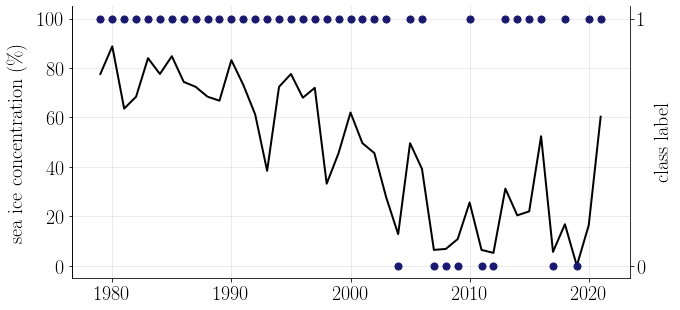

In [4]:
def readSIC():
    import glob
    import struct
    dimX = 448
    dimY = 304
    months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    SIC = {}
    SIC['lat'] = (np.fromfile("data/GRIDS/psn25lats_v3.dat",dtype='<i4').reshape(dimX,dimY))/100000
    SIC['lon'] = (np.fromfile("data/GRIDS/psn25lons_v3.dat",dtype='<i4').reshape(dimX,dimY))/100000
    SIC['psa'] = (np.fromfile("data/GRIDS/psn25area_v3.dat",dtype='<i4').reshape(dimX,dimY))/1000
    for month in range(7,8):
        monthID = str("%02d"%(month+1))
        days = sorted(glob.glob("data/SIC/daily/2021/nt_2021"+str(monthID)+"*.bin"))
        daily = np.zeros((dimX,dimY,len(days)))*np.nan
        monthly = np.zeros((dimX,dimY,2020-1979+1))*np.nan
        k = -1
        for d in days:
            k = k + 1
            icefile = open(d, "rb")
            contents = icefile.read()
            icefile.close()
            s="%dB" % (int(dimX*dimY),)
            z=struct.unpack_from(s, contents, offset = 300)
            daily[:,:,k] = np.array(z).reshape((dimX,dimY))
        daily = daily/250
        daily[daily>1]=np.nan       
        month_fm_daily = np.nanmean(daily, axis=2)
        k = 0
        for y in range(1979,2020+1):
            icefile = open(glob.glob("data/SIC/monthly/nt_"+str(y)+str(monthID)+"*.bin")[0], "rb")
            contents = icefile.read()
            icefile.close()
            s="%dB" % (int(dimX*dimY),)
            z=struct.unpack_from(s, contents, offset = 300)
            monthly[:,:,k] = np.array(z).reshape((dimX,dimY))
            k = k + 1
        monthly = monthly/250
        monthly[monthly>1]=np.nan
        data = np.concatenate((monthly,month_fm_daily[:,:,np.newaxis]),2)
        SIC[months[month]+'_data'] = data
    return SIC

SIC = readSIC()

ix = 200 ; jx = 100
cont = np.copy(SIC['aug_data'])
disc = np.copy(SIC['aug_data'])
disc[disc<0.15] = 0 ; disc[disc>=0.15] = 1
contc = np.copy(cont[ix,jx,:])
cont[ix,jx,:] = 100
discc = np.copy(disc[ix,jx,:])
disc[ix,jx,:] = 100

fig,ax1 = plt.subplots(1,sharex=True,figsize=(10,5))
ax2 = ax1.twinx()
ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax1.plot(np.arange(1979,2021+1),100*contc,color='k',lw=2)
ax1.set_ylabel('sea ice concentration ($\%$)',labelpad=10)
ax1.set_ylim(-5,105)
ax1.grid(True,alpha=.3)

ax2.scatter(np.arange(1979,2021+1),discc,color='midnightblue',s=50)
ax2.set_ylim(-0.05,1.05)
ax2.locator_params(axis='y', nbins=2)
ax2.set_ylabel('class label',labelpad=10)
plt.show()



# Figure 2.2: Linear OLS regression

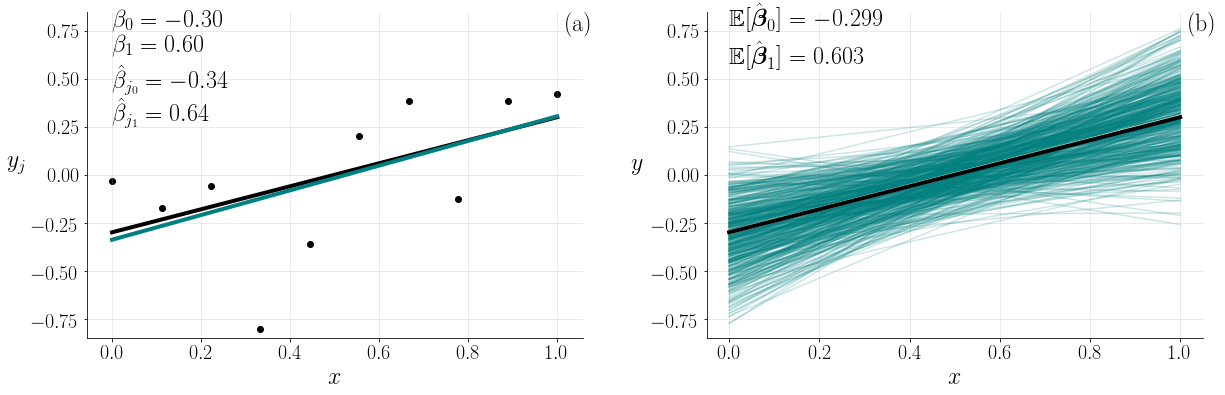

In [5]:
np.random.seed(20)


def f(x):
    return w0 + x*w1

fnt = 24
n = 10 #number of observations
sn2 = 0.3 #noise variance
w0 = -0.3 #true 'unknown' parameter
w1 = 0.6 #true 'unknown' parameter
x = np.array([np.ones(n),np.linspace(0,1,n)]).T 
y = f(x[:,1]) + np.random.normal(0,sn2,n)
L = np.linalg.cholesky(np.dot(x.T,x))
w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(x.T,y)))

fig,ax = plt.subplots(1,2,figsize=(20,6))
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].plot(x[:,1],x[:,1]*w1 + w0, color='k',linewidth=4)
ax[0].plot(x[:,1],x[:,1]*w_closed_form[1] + w_closed_form[0], color='teal',linewidth=4)
ax[0].scatter(x[:,1],y,color='k')
ax[0].set_xlabel('$x$',fontsize=24)
ax[0].set_ylabel('$y_j$',rotation=0, labelpad=15,fontsize=24)
ax[0].text(0.,.75,r'$\beta_0 = -0.30$',fontsize=fnt)
ax[0].text(0.,.62,r'$\beta_1 = 0.60$',fontsize=fnt)
ax[0].text(0.,.42,r'$\hat{\beta}_{j_0} = -0.34$',fontsize=fnt)
ax[0].text(0.,.25,r'$\hat{\beta}_{j_1} = 0.64$',fontsize=fnt)
ax[0].set_ylim(-0.85,0.85)
ax[0].grid(True,alpha=.3)
ax[0].text(1.02,0.75,'(a)',fontsize=fnt)

w0_est = np.zeros(10000) ; w1_est = np.zeros(10000)
fit = np.zeros((n,10000))
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
for N in range(500):
    y = f(x[:,1]) + np.random.normal(0,sn2,n)
    L = np.linalg.cholesky(np.dot(x.T,x))
    w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(x.T,y)))
    w0_est[N] = w_closed_form[0] ; w1_est[N] = w_closed_form[1]
    fit[:,N] = w0_est[N] + w1_est[N]*x[:,1]
    ax[1].plot(x[:,1],fit[:,N],color='teal',alpha=0.2)
ax[1].plot(x[:,1],w0_est[N] + w1_est[N]*x[:,1],color='teal',alpha=.2)
ax[1].plot(x[:,1],x[:,1]*0.603 + -0.2997,color='honeydew',alpha=1,linewidth=4)
ax[1].plot(x[:,1],x[:,1]*w1 + w0, color='k',linewidth=4, label='$f$')
ax[1].text(0.,.75,r'$\mathbb{E}[\hat{\boldsymbol{\beta}}_0] = -0.299$',fontsize=fnt)
ax[1].text(0.,.55,r'$\mathbb{E}[\hat{\boldsymbol{\beta}}_1] = 0.603$',fontsize=fnt)
ax[1].set_xlabel('$x$',fontsize=24)
ax[1].set_ylabel('$y$',rotation=0, labelpad=15,fontsize=24)
ax[1].set_ylim(-0.85,0.85)
ax[1].text(1.02,0.75,'(b)',fontsize=fnt)
ax[1].grid(True,alpha=.3)
plt.subplots_adjust(wspace=0.25)
plt.show()


# Figure 2.3: Non-linear (polynomial) OLS regression

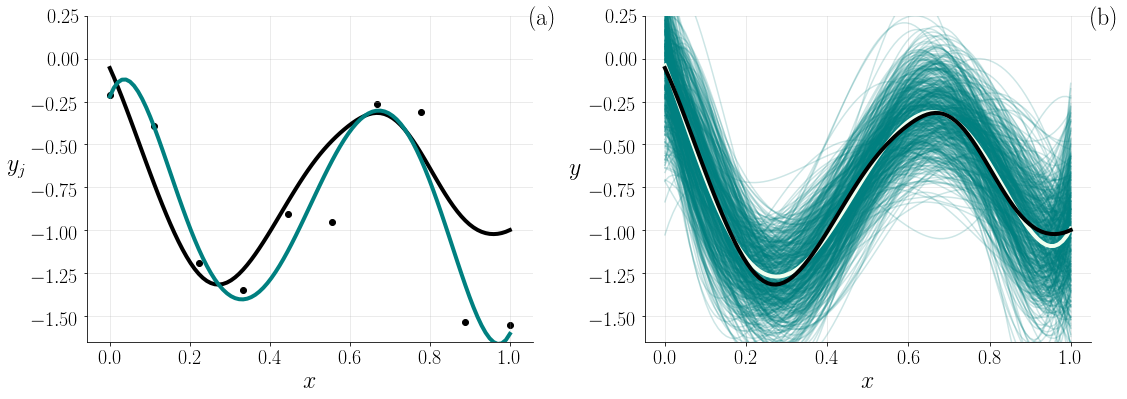

In [8]:
np.random.seed(20)

def powers(a,p):
    mapped = np.zeros((len(a),p+1))
    mapped[:,0] = np.ones(len(a))
    for ix in range(1,p+1):
        mapped[:,ix] = a**ix
    return mapped

def gauss(a,p,s=1):
    mapped = np.zeros((len(a),p+1))
    mapped[:,0] = np.ones(len(a))
    mu = [0,0.1,0.5,0.6]
    for ix in range(1,p+1):
        mapped[:,ix] = np.exp(-(a-mu[ix-1])**2/(2*s**2))
    return mapped

def f(x):
    np.random.seed(20)
    Q = squareform(pdist(np.atleast_2d(x/.5).T,'sqeuclidean'))
    k = (1 + Q/.5)**-.5
    return np.random.multivariate_normal(np.zeros(len(x)),k)#np.cos(2*np.pi*x)*np.cos(2*np.pi*x)

n = 10 #number of observations
sn2 = 0.3 #noise variance

x_smooth = np.linspace(0,1,100)
fx = f(x_smooth)
x = np.linspace(0,1,n)
f_x = np.array([fx[0],fx[11],fx[22],fx[33],fx[44],fx[55],fx[66],fx[77],fx[88],fx[99]])
y = f_x + np.random.normal(0,sn2,n)

X = powers(x,5)
X_smooth = powers(x_smooth,5)
L = np.linalg.cholesky(np.dot(X.T,X))
w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].plot(x_smooth,fx, color='k',linewidth=4, label='$f(x)$')
ax[0].plot(x_smooth,np.dot(X_smooth,w_closed_form), color='teal',linewidth=4, label='$\hat{f}_j(x)$')
ax[0].scatter(x,y,color='k',label='input-output pairs')
ax[0].set_xlabel('$x$',fontsize=24)
ax[0].set_ylabel('$y_j$',rotation=0, labelpad=15,fontsize=24)
ax[0].set_ylim(-1.65,.25)#-0.75,2.25)
ax[0].text(1.05,0.2,'(a)',fontsize=24)
ax[0].grid(True,alpha=.3)

fit = np.zeros((100,10000))
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
w_est = [-3.97935557e-02,-6.10858983e+00,-1.41791919e+01,1.14626628e+02,-1.71815457e+02,7.65258586e+01] #computed from earlier run
for N in range(500):
    y = f_x + np.random.normal(0,sn2,n)
    L = np.linalg.cholesky(np.dot(X.T,X))
    w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    fit[:,N] = np.dot(X_smooth,w_closed_form)
    ax[1].plot(x_smooth,fit[:,N],color='teal',alpha=0.2)
ax[1].plot(x_smooth,np.dot(X_smooth,w_closed_form),color='teal',alpha=.2,label='$\hat{f}_j(x)$')
ax[1].plot(x_smooth,np.dot(X_smooth,w_est),color='honeydew',alpha=1,linewidth=4,label='E[$\hat{f}(x)$]')
ax[1].plot(x_smooth,fx, color='k',linewidth=4, label='$f(x)$')
ax[1].set_xlabel('$x$',fontsize=24)
ax[1].set_ylabel('$y$',rotation=0, labelpad=15,fontsize=24)
ax[1].set_ylim(-1.65,.25)
ax[1].grid(True,alpha=.3)
ax[1].text(1.05,0.2,'(b)',fontsize=24)
plt.subplots_adjust(wspace=0.25)
plt.show()




# Figure 2.4: Model complexity vs over-fitting

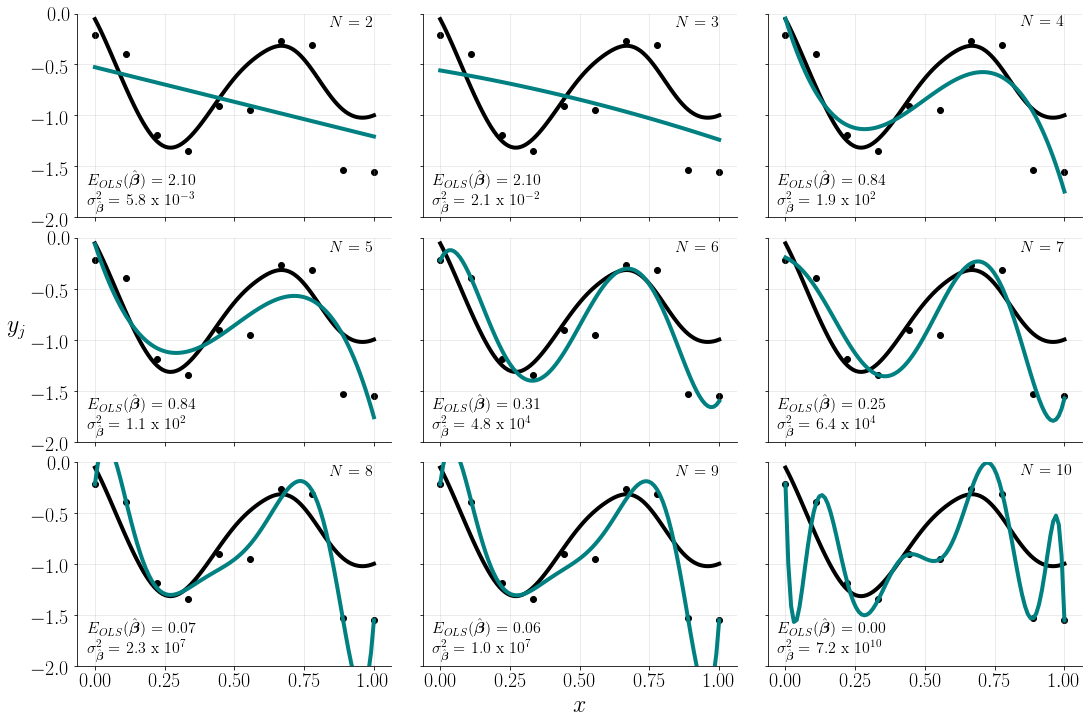

In [9]:
np.random.seed(20)

def powers(a,p):
    mapped = np.zeros((len(a),p+1))
    mapped[:,0] = np.ones(len(a))
    for ix in range(1,p+1):
        mapped[:,ix] = a**ix
    return mapped

def gauss(a,p,s=1):
    mapped = np.zeros((len(a),p+1))
    mapped[:,0] = np.ones(len(a))
    mu = [0,0.1,0.5,0.6]
    for ix in range(1,p+1):
        mapped[:,ix] = np.exp(-(a-mu[ix-1])**2/(2*s**2))
    return mapped

def f(x):
    np.random.seed(20)
    Q = squareform(pdist(np.atleast_2d(x/.5).T,'sqeuclidean'))
    k = (1 + Q/.5)**-.5
    return np.random.multivariate_normal(np.zeros(len(x)),k)

def regression(inputs,outputs,inputs2):
    L = np.linalg.cholesky(np.dot(inputs.T,inputs))
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(inputs.T,outputs)))
    E = np.sum((outputs - np.dot(inputs,w))**2).round(2)
    return np.dot(inputs2,w),E,np.var(w)

n = 10 #number of observations
sn2 = 0.3 #noise variance

x_smooth = np.linspace(0,1,100)
fx = f(x_smooth)
x = np.linspace(0,1,n)
f_x = np.array([fx[0],fx[11],fx[22],fx[33],fx[44],fx[55],fx[66],fx[77],fx[88],fx[99]])
y = f_x + np.random.normal(0,sn2,n)

X1 = powers(x,1) ; X_smooth1 = powers(x_smooth,1)
X2 = powers(x,2) ; X_smooth2 = powers(x_smooth,2)
X3 = powers(x,3) ; X_smooth3 = powers(x_smooth,3)
X4 = powers(x,4) ; X_smooth4 = powers(x_smooth,4)
X5 = powers(x,5) ; X_smooth5 = powers(x_smooth,5)
X6 = powers(x,6) ; X_smooth6 = powers(x_smooth,6)
X7 = powers(x,7) ; X_smooth7 = powers(x_smooth,7)
X8 = powers(x,8) ; X_smooth8 = powers(x_smooth,8)
X9 = powers(x,9) ; X_smooth9 = powers(x_smooth,9)

w1,E1,v1 = regression(X1,y,X_smooth1)
w2,E2,v2 = regression(X2,y,X_smooth2)
w3,E3,v3 = regression(X3,y,X_smooth3)
w4,E4,v4 = regression(X4,y,X_smooth4)
w5,E5,v5 = regression(X5,y,X_smooth5)
w6,E6,v6 = regression(X6,y,X_smooth6)
w7,E7,v7 = regression(X7,y,X_smooth7)
w8,E8,v8 = regression(X8,y,X_smooth8)
w9,E9,v9 = regression(X9,y,X_smooth9)

fits = [w1,w2,w3,w4,w5,w6,w7,w8,w9]
E = [E1,E2,E3,E4,E5,E6,E7,E8,E9]
var = ['5.8 x 10$^{-3}$','2.1 x 10$^{-2}$','1.9 x 10$^2$','1.1 x 10$^2$','4.8 x 10$^4$',\
      '6.4 x 10$^4$','2.3 x 10$^7$','1.0 x 10$^7$','7.2 x 10$^{10}$']
fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(18,12))
k = 0
for row in range(3):
    for col in range(3):
        ax[row,col].spines['top'].set_color('none')
        ax[row,col].spines['right'].set_color('none')
        ax[row,col].plot(x_smooth,fx, color='k',linewidth=4)
        ax[row,col].scatter(x,y,color='k')
        ax[row,col].plot(x_smooth,fits[k], color='teal',linewidth=4)
        ax[row,col].text(0.84,-0.13,'$N=$ '+str((k+2)),fontsize=16)
        ax[row,col].text(-0.03,-1.7,r'$E_{OLS}(\hat{\boldsymbol{\beta}})=$ '+str('%.2f'%E[k]),fontsize=16)
        ax[row,col].text(-0.03,-1.94,r'$\sigma^2_{\hat{\boldsymbol{\beta}}}=$ '+var[k],fontsize=16)
        ax[row,col].set_ylim(-2,0)
        ax[row,col].grid(True,alpha=.3)
        if k == 3:
            ax[row,col].set_ylabel('$y_j$',rotation=0, labelpad=15,fontsize=24)
        if k == 7:
            ax[row,col].set_xlabel('$x$',fontsize=24)
        k += 1
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.show()

# Figure 2.5: Lasso vs Ridge shrinkage

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  after removing the cwd from sys.path.


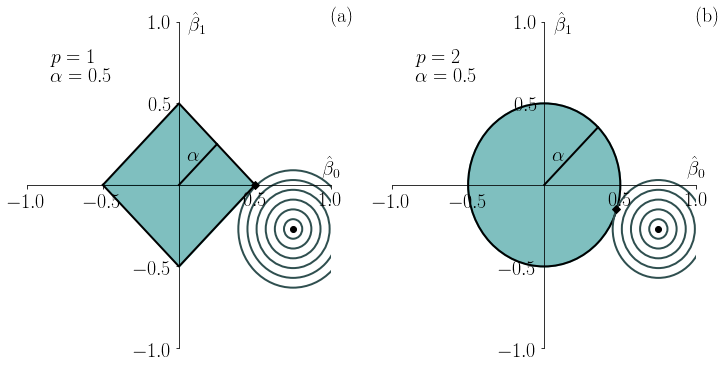

In [10]:
ols_point_x = 0.75
ols_point_y = -.27
ridge1 = plt.Circle((0,0),0.5,color='teal',fill=True,alpha=.5,edgecolor='k',linewidth=2)
ridge2 = plt.Circle((0,0),0.5,color='k',fill=False,alpha=1,edgecolor='k',linewidth=2)
lasso = [[-.5,0,.5,0,-.5],[0,.5,0,-.5,0]]
OLS1 = plt.Circle((ols_point_x,ols_point_y),0.36,color='darkslategrey',fill=False,linewidth=2)
OLS2 = plt.Circle((ols_point_x,ols_point_y),0.3,color='darkslategrey',fill=False,linewidth=2)
OLS3 = plt.Circle((ols_point_x,ols_point_y),0.24,color='darkslategrey',fill=False,linewidth=2)
OLS4 = plt.Circle((ols_point_x,ols_point_y),0.18,color='darkslategrey',fill=False,linewidth=2)
OLS5 = plt.Circle((ols_point_x,ols_point_y),0.12,color='darkslategrey',fill=False,linewidth=2)
OLS6 = plt.Circle((ols_point_x,ols_point_y),0.06,color='darkslategrey',fill=False,linewidth=2)
OLS7 = plt.Circle((ols_point_x,ols_point_y),0.3,color='darkslategrey',fill=False,linewidth=2)
OLS8 = plt.Circle((ols_point_x,ols_point_y),0.24,color='darkslategrey',fill=False,linewidth=2)
OLS9 = plt.Circle((ols_point_x,ols_point_y),0.18,color='darkslategrey',fill=False,linewidth=2)
OLS10 = plt.Circle((ols_point_x,ols_point_y),0.12,color='darkslategrey',fill=False,linewidth=2)
OLS11 = plt.Circle((ols_point_x,ols_point_y),0.06,color='darkslategrey',fill=False,linewidth=2)

fig,ax = plt.subplots(1,2,figsize=(12,6))
for c in range(2):
    ax[c].spines['top'].set_color('none')
    ax[c].spines['bottom'].set_position('zero')
    ax[c].spines['left'].set_position('zero')
    ax[c].spines['right'].set_color('none')
    if c == 0:
        ax[c].plot(lasso[0],lasso[1],color='k',linewidth=2)
        ax[c].plot([0,.25],[0,.25],color='k',linewidth=2)
        ax[c].fill_between([.5,0],[0,.5],color='teal',alpha=.5)
        ax[c].fill_between([-.5,0],[0,.5],color='teal',alpha=.5)
        ax[c].fill_between([-.5,0],[0,-.5],color='teal',alpha=.5)
        ax[c].fill_between([.5,0],[0,-.5],color='teal',alpha=.5)
        ax[c].text(0.05,0.15,r'$\alpha$')
        ax[c].text(-.85,.75,'$p = 1$')
        ax[c].text(-.85,.63,r'$\alpha = 0.5$')
        ax[c].text(1,1,'(a)')
        ax[c].scatter(ols_point_x,ols_point_y,color='k',label=r'$(\hat{\beta}_0,\hat{\beta}_1)_{OLS}$')
        ax[c].add_artist(OLS1) ; ax[c].add_artist(OLS2) ; ax[c].add_artist(OLS3)
        ax[c].add_artist(OLS4) ; ax[c].add_artist(OLS5) ; ax[c].add_artist(OLS6)
        ax[c].plot(.5,0,'kD')
    else:
        ax[c].add_artist(ridge1)
        ax[c].add_artist(ridge2)
        ax[c].plot([0,np.sqrt(.25**2+.25**2)],[0,np.sqrt(.25**2+.25**2)],color='k',linewidth=2)
        ax[c].text(-.85,.75,'$p = 2$')
        ax[c].text(0.05,0.15,r'$\alpha$')
        ax[c].text(-.85,.63,r'$\alpha = 0.5$')
        ax[c].text(1,1,'(b)')
        ax[c].add_artist(OLS7) ; ax[c].add_artist(OLS8) ; ax[c].add_artist(OLS9) ; ax[c].add_artist(OLS10)
        ax[c].add_artist(OLS11)
        ax[c].scatter(ols_point_x,ols_point_y,color='k')
        ax[c].plot(np.sqrt(.47**2),-np.sqrt(.15**2),'kD')
    ax[c].set_xlim(-1,1)
    ax[c].set_ylim(-1,1)
    ax[c].set_xticks([-1,-.5,.5,1])
    ax[c].set_yticks([-1,-.5,.5,1])
    ax[c].set_xlabel(r'$\hat\beta_0$')
    ax[c].set_ylabel(r'$\hat\beta_1$',rotation=0)
    ax[c].xaxis.set_label_coords(1, .58)
    ax[c].yaxis.set_label_coords(0.56, 0.95)
plt.show()

# Figure 2.6: Non-linear OLS vs Ridge regression

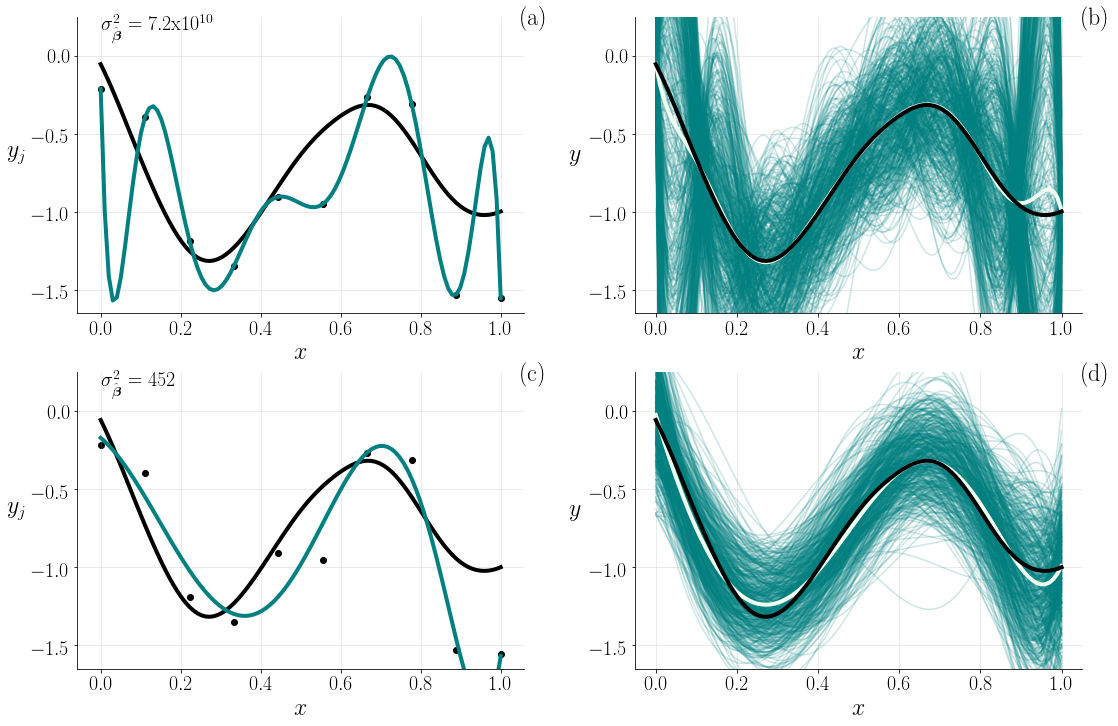

In [11]:
np.random.seed(20)

def powers(a,p):
    mapped = np.zeros((len(a),p+1))
    mapped[:,0] = np.ones(len(a))
    for ix in range(1,p+1):
        mapped[:,ix] = a**ix
    return mapped

def f(x):
    np.random.seed(20)
    Q = squareform(pdist(np.atleast_2d(x/.5).T,'sqeuclidean'))
    k = (1 + Q/.5)**-.5
    return np.random.multivariate_normal(np.zeros(len(x)),k)#np.cos(2*np.pi*x)*np.cos(2*np.pi*x)

n = 10 #number of observations
sn2 = 0.3 #noise variance

x_smooth = np.linspace(0,1,100)
fx = f(x_smooth)
x = np.linspace(0,1,n)
f_x = np.array([fx[0],fx[11],fx[22],fx[33],fx[44],fx[55],fx[66],fx[77],fx[88],fx[99]])
y = f_x + np.random.normal(0,sn2,n)

X = powers(x,9)
X_smooth = powers(x_smooth,9)
L = np.linalg.cholesky(np.dot(X.T,X))
w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
var = np.var(w_closed_form)
fig,ax = plt.subplots(2,2,figsize=(18,12))
ax[0,0].spines['top'].set_color('none')
ax[0,0].spines['right'].set_color('none')
ax[0,0].plot(x_smooth,fx, color='k',linewidth=4, label='$f(x)$')
ax[0,0].plot(x_smooth,np.dot(X_smooth,w_closed_form), color='teal',linewidth=4, label='$\hat{f}_j(x)$')
ax[0,0].scatter(x,y,color='k',label='input-output pairs')
ax[0,0].set_xlabel('$x$',fontsize=24)
ax[0,0].set_ylabel('$y_j$',rotation=0, labelpad=15,fontsize=24)
ax[0,0].set_ylim(-1.65,.25)#-0.75,2.25)
ax[0,0].text(1.05,0.2,'(a)',fontsize=24)
ax[0,0].grid(True,alpha=.3)
ax[0,0].text(0,0.1,r'$\sigma^2_{\hat{\boldsymbol{\beta}}}=7.2 $x$ 10^{10}$')

fit = np.zeros((100,10000))
ax[0,1].spines['top'].set_color('none')
ax[0,1].spines['right'].set_color('none')
w_est = [-5.22500822e-02, -1.50099901e+01,  2.26260405e+02, -2.27902616e+03,\
        1.18211623e+04, -3.39916155e+04,  5.73532400e+04, -5.66965551e+04,3.04068092e+04, -6.82620753e+03]
for N in range(500):
    yi = f_x + np.random.normal(0,sn2,n)
    L = np.linalg.cholesky(np.dot(X.T,X))
    w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,yi)))
    fit[:,N] = np.dot(X_smooth,w_closed_form)
    ax[0,1].plot(x_smooth,fit[:,N],color='teal',alpha=0.2)
ax[0,1].plot(x_smooth,np.dot(X_smooth,w_closed_form),color='teal',alpha=.2,label='$\hat{f}_j(x)$')
ax[0,1].plot(x_smooth,np.dot(X_smooth,w_est),color='honeydew',alpha=1,linewidth=4,label='E[$\hat{f}(x)$]')
ax[0,1].plot(x_smooth,fx, color='k',linewidth=4, label='$f(x)$')
ax[0,1].set_xlabel('$x$',fontsize=24)
ax[0,1].set_ylabel('$y$',rotation=0, labelpad=15,fontsize=24)
ax[0,1].set_ylim(-1.65,.25)
ax[0,1].text(1.05,0.2,'(b)',fontsize=24)
ax[0,1].grid(True,alpha=.3)

L = np.linalg.cholesky(np.dot(X.T,X) + np.eye(10)*5e-6)
w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
ax[1,0].spines['top'].set_color('none')
ax[1,0].spines['right'].set_color('none')
ax[1,0].plot(x_smooth,fx, color='k',linewidth=4, label='$f(x)$')
ax[1,0].plot(x_smooth,np.dot(X_smooth,w_closed_form), color='teal',linewidth=4, label='$\hat{f}_j(x)$')
ax[1,0].scatter(x,y,color='k',label='input-output pairs')
ax[1,0].set_xlabel('$x$',fontsize=24)
ax[1,0].set_ylabel('$y_j$',rotation=0, labelpad=15,fontsize=24)
ax[1,0].set_ylim(-1.65,.25)#-0.75,2.25)
ax[1,0].text(1.05,0.2,'(c)',fontsize=24)
ax[1,0].text(0,0.1,r'$\sigma^2_{\hat{\boldsymbol{\beta}}}=452$')
ax[1,0].grid(True,alpha=.3)

fit = np.zeros((100,10000))
ax[1,1].spines['top'].set_color('none')
ax[1,1].spines['right'].set_color('none')
w_est = [-0.02322288,-8.68160995,12.55955404,16.4585178,-16.00213024,\
        -18.56970381,-2.97693286,10.45058718,10.74627382,-4.95161348]
for N in range(500):
    yi = f_x + np.random.normal(0,sn2,n)
    L = np.linalg.cholesky(np.dot(X.T,X) + np.eye(10)*5e-6)
    w_closed_form = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,yi)))
    fit[:,N] = np.dot(X_smooth,w_closed_form)
    ax[1,1].plot(x_smooth,fit[:,N],color='teal',alpha=0.2)
ax[1,1].plot(x_smooth,np.dot(X_smooth,w_closed_form),color='teal',alpha=.2,label='$\hat{f}_j(x)$')
ax[1,1].plot(x_smooth,np.dot(X_smooth,w_est),color='honeydew',alpha=1,linewidth=4,label='E[$\hat{f}(x)$]')
ax[1,1].plot(x_smooth,fx, color='k',linewidth=4, label='$f(x)$')
ax[1,1].set_xlabel('$x$',fontsize=24)
ax[1,1].set_ylabel('$y$',rotation=0, labelpad=15,fontsize=24)
ax[1,1].set_ylim(-1.65,.25)
ax[1,1].text(1.05,0.2,'(d)',fontsize=24)
ax[1,1].grid(True,alpha=.3)
plt.subplots_adjust(wspace=0.25)
plt.show()




# Figure 2.7: Bayesian linear regression

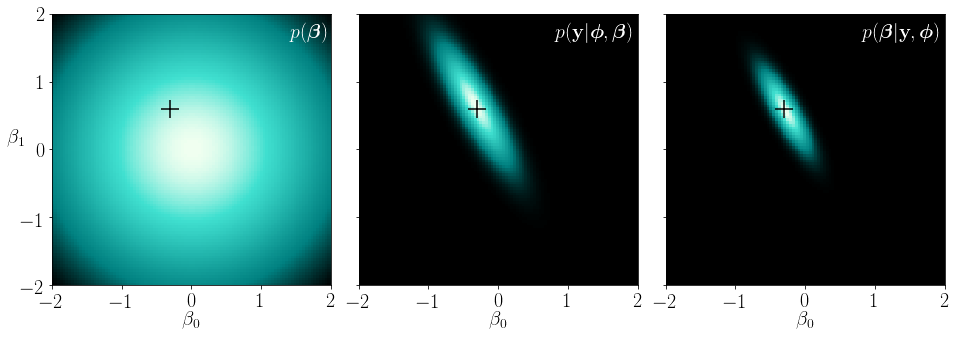

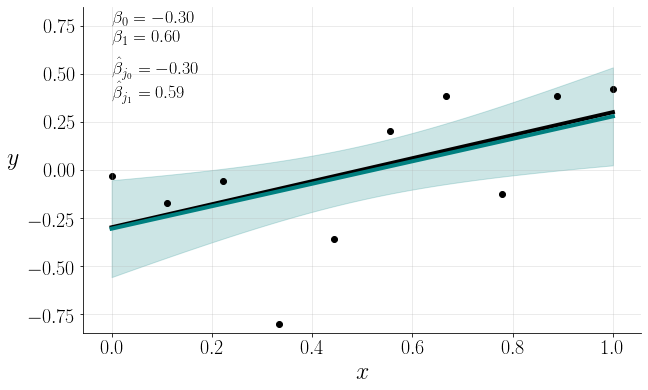

In [15]:
np.random.seed(20)

norm = mpl.colors.Normalize(0,1)
colors = [[norm(0), "black"],[norm(0.25),"teal"],[norm(0.5), "lightseagreen"],\
          [norm(.75),"turquoise"],[norm(1),"honeydew"]]
tealz = mpl.colors.LinearSegmentedColormap.from_list("", colors)

#CREATE LINEAR TRAINING DATA, THE 'UNKNOWN' PARAMETERS OF WHICH WE WISH TO LEARN
w0_true = -0.3
w1_true = 0.6
n = 10
M = 100
sn2 = 0.3
x = np.linspace(0,1,n)
noise = np.random.normal(0,sn2,n)
w0_samples = np.linspace(-2,2,M)
w1_samples = np.linspace(-2,2,M)
w0,w1 = np.meshgrid(w0_samples,w1_samples)

y = (w0_true + x*w1_true) + noise

#GET LIKELIHOOD AND POSTERIOR (see e.g eq 2.3 and 2.7 Rasmussen and Williams, 2006)
constant = (1/(2*np.pi*sn2)**(n/2))
likelihood = np.zeros((M,M))
posterior = np.zeros((M,M))
μ_prior = np.zeros(2) #prior mean
Σ_prior = np.eye(2)*2.5 #prior covariance
X = np.asarray([np.ones(n),x]).T
w_mean = μ_prior + (1/sn2)*mdot([np.linalg.inv((1/sn2)*np.dot(X.T,X) + np.diag(1/Σ_prior.diagonal())),X.T,y - np.dot(X,μ_prior)])
for ix in range(M):
    for jx in range(M):
        w = np.asarray([w0[ix,jx],w1[ix,jx]])
        likelihood[ix,jx] = constant * np.exp(-np.dot((y - np.dot(X,w)).T,y - np.dot(X,w))/(2*sn2))
        posterior[ix,jx] = np.exp(-mdot([(w-w_mean).T,(1/sn2)*np.dot(X.T,X) + np.diag(1/Σ_prior.diagonal()),(w-w_mean)]))

#PLOT PRIOR --> LIKELIHOOD --> POSTERIOR
fig,ax = plt.subplots(1,3,sharey=True,figsize=(16,5))
prior = stats.multivariate_normal([0, 0], [[2.5, 0], [0, 2.5]])
pos = np.empty(w0.shape + (2,))
pos[:, :, 0] = w0 ; pos[:, :, 1] = w1
data = [prior.pdf(pos),likelihood,posterior] ; captions = [r'$p(\boldsymbol{\beta})$',\
                                                           r'$p(\textbf{y}|\boldsymbol{\phi},\boldsymbol{\beta})$',\
                                                           r'$p(\boldsymbol{\beta}|\textbf{y},\boldsymbol{\phi})$']
label = [1.4,.8,.8]
for c in range(3):
    s = ax[c].pcolor(w0,w1,data[c], cmap=tealz, rasterized=True)
    if c == 0:
        ax[c].set_ylabel(r'$\beta_1$', rotation=0)
    ax[c].set_xlabel(r'$\beta_0$') 
    ax[c].set_ylim(-2,2,0.5)
    ax[c].scatter(w0_true,w1_true, marker='+',color='k', s=300)
    ax[c].text(label[c],1.65,captions[c],fontsize=20,color='white')
plt.subplots_adjust(wspace=0.1)
plt.show()

#In practice we wouldn't perform BLR like the above. Let's do an example of a practical implementation:
n = 10
ϕ = np.asarray([np.ones(n),x]).T #use same data as previously but augment x with a vector of 1s (for the bias term)
sn2 = 0.2
M = 2 #there are 2 parameters we want to learn, the gradient and the bias term.

#define the prior w ~ N(0,Σ_prior) eq 2.4 Rasmussen and Williams, 2006
μ_prior = np.zeros(M) #zero mean prior 
Σ_prior = np.eye(M)*2.5 #prior covariance matrix
y_ = y - np.dot(ϕ,μ_prior) #compute this here for convenience

#Compute based on equation 2.11 of Rasmussen and Williams, 2006
A = (1/sn2)*np.dot(ϕ.T,ϕ) + np.diag(1/Σ_prior.diagonal()) #inverse of a diagonal matrix = 1/diagonal_elements
L = np.linalg.cholesky(A)
μ_posterior = μ_prior + (1/sn2)*np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ.T,y_)))
#note that the above expression is essentially written as (sn2^-1ϕ.Tϕ + Σ_prior^-1)^-1ϕ.Ty.
#The posterior of the regression weights is given by: p(w|y,ϕ) \propto exp(-1/2*sn2 * (y-ϕw)^2) * exp(-w^TΣ_priorw/2)
#If we maximise the logarithm of the posterior distribution with respect to w, then this is equivalent to the 
#minimisation of the sum of squares error function with an additional quadratic penalty term, i.e Ridge Regression.
#In ridge regression the quadratic penalty is λw^Tw/2. In BLR it is w^TΣ_priorw/2sn2
Σ_posterior = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(M))) #covariance matrix of the posterior distribution

ϕs = np.asarray([np.ones(100),np.linspace(0,1,100)]).T
K = mdot([ϕ,Σ_prior,ϕ.T]) + sn2*np.eye(n) #this is our linear kernel function (n x n Gram matrix)
k = mdot([ϕs,Σ_prior,ϕ.T]) #covariance between test inputs and training inputs
ks = mdot([ϕs,Σ_prior,ϕs.T]) #covariance between test inputs
L = np.linalg.cholesky(K) 
α1 = np.linalg.solve(L.T,np.linalg.solve(L,y_))

v = np.linalg.solve(L.T,np.linalg.solve(L,k.T))
ys2 = np.dot(k,α1) #predictive mean
sn2s2 = (ks - np.dot(k,v)).diagonal() #predictive variance

xs = np.linspace(0,1,100)
#PLOT TRAINING DATA
fig,ax = plt.subplots(1,figsize=(10,6))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.plot(x,x*w1_true + w0_true, color='k',linewidth=4, label='$f$')
ax.plot(xs,ys2,color='teal',linewidth=4)
ax.fill_between(xs,ys2-np.sqrt(sn2s2),ys2+np.sqrt(sn2s2),color='teal',alpha=.2)
ax.scatter(x,y,color='k')
ax.set_xlabel('$x$',fontsize=24)
ax.set_ylabel('$y$',rotation=0, labelpad=15,fontsize=24)
ax.text(0.,.75,r'$\beta_0 = -0.30$',fontsize=18)
ax.text(0.,.65,r'$\beta_1 = 0.60$',fontsize=18)
ax.text(0.,.475,r'$\hat{\beta}_{j_0} = -0.30$',fontsize=18)
ax.text(0.,.35,r'$\hat{\beta}_{j_1} = 0.59$',fontsize=18)
ax.set_ylim(-0.85,0.85)
ax.grid(True,alpha=.3)
plt.show()

# Figure 2.8: Trends in winter sea ice age

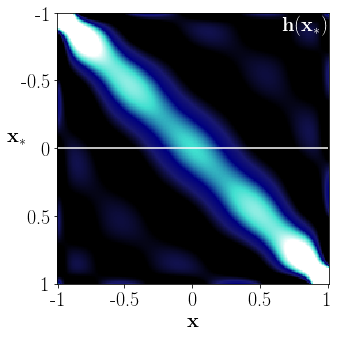

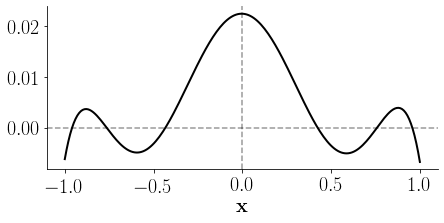

In [17]:
np.random.seed(2)

def f(x):
    np.random.seed(20)
    Q = squareform(pdist(np.atleast_2d(x/.5).T,'sqeuclidean'))
    k = (1 + Q/.5)**-.5
    return np.random.multivariate_normal(np.zeros(len(x)),k)

def powers(a,p):
    mapped = np.zeros((len(a),p+1))
    mapped[:,0] = np.ones(len(a))
    for ix in range(1,p+1):
        mapped[:,ix] = a**ix
    return mapped.T

#Generate some synthetic data
n = 200 #number of observations
sn2 = 0.5 #noise variance
x = np.linspace(-1,1,n) #inputs
xs = np.linspace(-1.5,1.5,200)
phi = powers(x,6) #polynomial basis function projection
phis = powers(xs,6) #polynomial basis function projection
N = phi.shape[0] #number of parameters
fx = f(x) #true function values drawn from a Gaussian process
y = fx + np.random.normal(0,sn2,n) #add random Gaussian noise to produce outputs

Vi = np.eye(n)/sn2 #inverse covariance of the likelihood distribution
Sigmai = np.eye(N)/100 #inverse prior covariance over the regression parameters

#Generate mean of predictive distribution
phi_mu_tilde = mdot([phi.T,np.linalg.inv(mdot([phi,Vi,phi.T]) + Sigmai),phi,Vi,y]) #posterior predictive distribution at phi

kx = mdot([phi.T,np.linalg.inv(mdot([phi,Vi,phi.T]) + Sigmai),phi,Vi]) #equivalent kernel

norm = mpl.colors.Normalize(0,1)
colors = [[norm(0), "black"],[norm(0.25),"midnightblue"],[norm(0.5), "navy"],\
          [norm(.75),"turquoise"],[norm(1),"white"]]
tealz = mpl.colors.LinearSegmentedColormap.from_list("", colors)

#plot kernel and extract profiles 
fig,ax = plt.subplots(1,figsize=(5,5))
ax.imshow(kx,cmap=tealz,vmin=0,vmax=0.03)
ax.set_xticks([0,49,99,149,199])
ax.set_xticklabels([-1,-0.5,0,0.5,1])
ax.set_yticks([0,49,99,149,199])
ax.set_yticklabels([-1,-0.5,0,0.5,1])
ax.set_ylabel(r'$\textbf{x}_*$',rotation=0)
ax.set_xlabel(r'$\textbf{x}$')
ax.hlines(99,199,0,color='white',alpha=1)
ax.text(165,15,r'$\textbf{h}(\textbf{x}_*)$',color='white')
plt.show()

fig,ax = plt.subplots(1,figsize=(7,3))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.plot(x,kx[:,99],color='k',lw=2)
ax.axhline(0,0,1,linestyle='--',color='k',alpha=.4)
ax.axvline(0,0,1,linestyle='--',color='k',alpha=.4)
ax.set_xlabel(r'$\textbf{x}$',)
plt.show()




# Figure 2.9: The joint Gaussian distribution

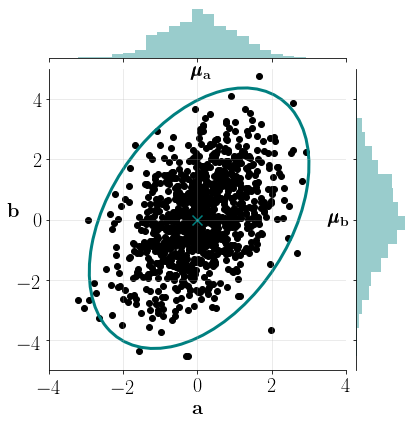

In [20]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

np.random.seed(1)
n = 1000
a = np.random.multivariate_normal([0,0],np.reshape([1,3/5,3/5,2],(2,2)),n)

h = sns.jointplot(x=a[:,0],y=a[:,1],height=6,kind='scatter',color='k',marginal_kws=dict(color='teal',bins=20))
h.ax_joint.set_xlabel(r'$\textbf{a}$')
h.ax_joint.set_ylabel(r'$\textbf{b}$',rotation=0)
confidence_ellipse(a[:,0],a[:,1],ax=h.ax_joint.axes,n_std=3,edgecolor='teal',lw=3)
h.ax_joint.scatter(0,0,color='teal',marker='x',s=100)
h.ax_joint.set_xlim([-4,4])
h.ax_joint.text(-0.2,4.7,r'$\pmb{\mu}_{\textbf{a}}$')
h.ax_joint.text(3.5,-0.2,r'$\pmb{\mu}_{\textbf{b}}$')
h.ax_joint.set_ylim([-5,5])
h.ax_joint.grid(True,alpha=.3)
plt.show()

# Figure 2.10: Gaussian process regression

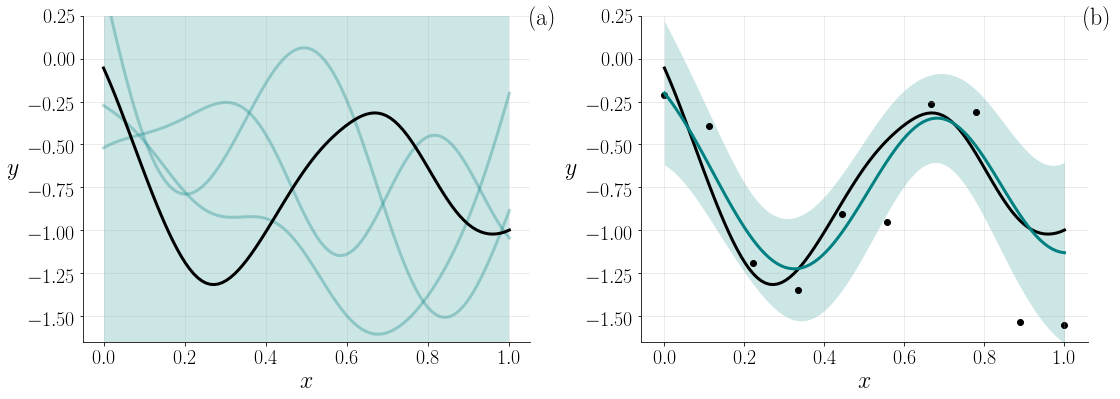

In [21]:
np.random.seed(20)
        
def f(x,seed=None):
    if seed:
        np.random.seed(seed)
    Q = squareform(pdist(x/.5,'sqeuclidean'))
    k = (1 + Q/.5)**-.5
    return np.random.multivariate_normal(np.zeros(len(x)),k)

def f2(x,seed=None): #prior
    if seed:
        np.random.seed(seed)
    k = .85 * np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean')))
    m = np.zeros(len(x))
    return np.random.multivariate_normal(m,k)

def fs(x,xs,seed=None): #posterior
    if seed:
        np.random.seed(seed)
    kx = sf2 * np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) + np.diag(sn2)
    kxs = sf2 * np.exp(-.5*cdist(xs/ell,x/ell,'sqeuclidean'))
    kss = sf2 * np.exp(-.5*squareform(pdist(xs/ell,'sqeuclidean')))
    L = np.linalg.cholesky(kx)
    α1 = np.linalg.solve(L.T,np.linalg.solve(L,y))
    α2 = np.linalg.solve(L.T,np.linalg.solve(L,kxs.T))
    k = kss - np.dot(kxs,α2)
    m = np.dot(kxs,α1)
    return np.random.multivariate_normal(m,k)

n = 10 #training points
ns = 100 #test points
x = np.linspace(0,1,n).reshape(n,1) #training inputs
xs = np.linspace(0,1,ns).reshape(ns,1) #test inputs
sn2 = np.ones(n)*.3
sn2[2] = .1 ; sn2[6] = .1 ;  sn2[-1] = 0.6 ; sn2[-2] = .6

fx = f(xs,20)
f_x = np.array([fx[0],fx[11],fx[22],fx[33],fx[44],fx[55],fx[66],fx[77],fx[88],fx[99]])
y = f_x + np.random.normal(0,.3,n)


sf2 = 1
ell = .2

#generate actual mean and variance of the prior
fmean_p = np.zeros(ns)
fvar_p = sf2 * np.exp(-.5*squareform(pdist(xs/ell,'sqeuclidean'))) + np.eye(ns)*.3

#draw samples from the prior
p1 = f2(xs,7) 
p2 = f2(xs,38)
p3 = f2(xs,69)

#draw samples from the posterior
fs1 = fs(x,xs,7)
fs2 = fs(x,xs,37)
fs3 = fs(x,xs,70)

#generate actual mean and variance of posterior
kx = sf2 * np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) + np.diag(sn2)
kxs = sf2 * np.exp(-.5*cdist(xs/ell,x/ell,'sqeuclidean'))
kss = sf2 * np.exp(-.5*squareform(pdist(xs/ell,'sqeuclidean')))

L = np.linalg.cholesky(kx)
α1 = np.linalg.solve(L.T,np.linalg.solve(L,y))
α2 = np.linalg.solve(L.T,np.linalg.solve(L,kxs.T))
fvar = kss - np.dot(kxs,α2)
fmean = np.dot(kxs,α1)

fig,ax = plt.subplots(1,2,figsize=(18,6))
for c in range(2):
    ax[c].spines['top'].set_color('none')
    ax[c].spines['right'].set_color('none')
    ax[c].grid(True,alpha=.3)
    ax[c].set_ylim(-1.65,.25)
    ax[c].set_ylabel('$y$',rotation=0,labelpad=15,fontsize=24)
    ax[c].set_xlabel('$x$',fontsize=24)
    if c == 0:
        ax[c].plot(xs,p1,color='teal',lw=3.,alpha=.3)
        ax[c].plot(xs,p2,color='teal',lw=3.,alpha=.3)
        ax[c].plot(xs,p3,color='teal',lw=3.,alpha=.3)
        ax[c].plot(xs,fx,color='k',lw=3.)
        ax[c].fill_between(xs[:,0],fmean_p + 3*np.sqrt(fvar_p.diagonal()), fmean_p - 3*np.sqrt(fvar_p.diagonal()),\
                color='teal',alpha=0.2,linewidths=0.0)
    else:
        ax[c].plot(xs,fx,color='k',lw=3.)
        ax[c].plot(xs,fmean,color='teal',lw=3.)
        ax[c].fill_between(xs[:,0],fmean + 1*np.sqrt(fvar.diagonal()), fmean - 1*np.sqrt(fvar.diagonal()),\
                        color='teal',alpha=0.2,linewidths=0.0)
        ax[c].scatter(x,y,color='k')

ax[0].text(1.05,0.2,'(a)',fontsize=24)
ax[1].text(1.05,0.2,'(b)',fontsize=24)
plt.subplots_adjust(wspace=0.25)
plt.show()

#In the first image the shaded area represents the prior space of functions. This means we expect our data to be
#generated from any function that falls within this range. Note that a prior over functions mean theoretically we
#place a prior over an infinite number of different functions. Here we show just 3 of them as an example. In the
#second image we see our training observations, where we can then 'condition' the prior distribution on the
#observations to create the posterior over functions. Here we plot 3 functions (coloured) drawn from this posterior,
#and then the actual mean and variance (3 standard devs) of the posterior in black/grey.



# Figure 2.11: Bayesian model selection (empirical Bayes)

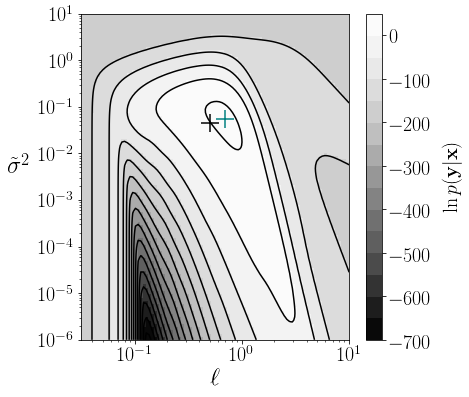

In [22]:
np.random.seed(1)

def f(x): #prior
    k = sf2_true * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell_true))
    m = np.zeros(len(x))
    return np.random.multivariate_normal(m,k)

def MLII(hyperparameters,penalty=True): #empirical Bayesian approach known as type-II maximum likelihood
    ell = np.exp(hyperparameters[0]) ; sn2_hat = np.exp(2*hyperparameters[1])
    try:
        L = np.linalg.cholesky(np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) + np.eye(n)*sn2_hat)
        α = ((np.linalg.solve(L.T,np.linalg.solve(L,y))).reshape(n,1))
        sf2 = np.dot(y.T,α)/n ; sn2 = sf2*sn2_hat
        L = np.linalg.cholesky(sf2 * np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) + np.eye(n)*sn2)
        α = (np.linalg.solve(L.T,np.linalg.solve(L,y))).reshape(n,1)
        if penalty:
            nlZ = np.dot(y.T,α)/2 + np.log(L.diagonal()).sum() + n*np.log(2*np.pi)/2 #Algorithm 2.1 R&W
        else:
            nlZ = np.log(L.diagonal()).sum()
        
        Q = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(n))) - np.dot(α,α.T)
        dK1 = sf2 * np.exp(-.5*squareform(pdist(x/ell,'sqeuclidean'))) * squareform(pdist(x/ell,'sqeuclidean'))
        dnlZ = [(Q*dK1).sum()/2,sn2_hat*np.trace(Q)] 
        
    except (np.linalg.LinAlgError) as e:
        nlZ = np.inf ; dnlZ = np.array([np.inf,np.inf])
    return nlZ,np.array(dnlZ)


n = 100 #training points
sf2_true = 2.2 #signal variance (hyperparameter)
ell_true = 0.5 #length scale (hyperparameter)
sn2_true = 0.1 #noise variance (hyperparameter)
sn2_hat_true = sn2_true/sf2_true
#the above hyperparameters are what we would like to recover by maximising the log marginal likelihood, or
#equivalently, minimising the negative log marginal likelihood

x = np.linspace(0,5,n).reshape(n,1) #training inputs
y = f(x) + np.random.normal(0,sn2_true,n)
  
t = 100
ell = np.logspace(-1.5,1,t)
sn2_hat = np.logspace(-6,1,t)
ell,sn2_hat = np.meshgrid(ell,sn2_hat)
nlML = np.zeros((t,t))
nlML_minus_penalty = np.zeros((t,t))
for ix in range(t):
    for jx in range(t):
        nlML[ix,jx] = MLII([np.log(ell[ix,jx]),np.log(sn2_hat[ix,jx])])[0]
        nlML_minus_penalty[ix,jx] = MLII([np.log(ell[ix,jx]),np.log(sn2_hat[ix,jx])],penalty=False)[0]

fig,ax = plt.subplots(1,sharey=True,figsize=(6,6))
plots = [nlML,nlML_minus_penalty]
mpl.rcParams['contour.negative_linestyle'] = 'solid'
s = plt.pcolor(ell,sn2_hat,-nlML,cmap=cmap_discretize('Greys_r',15),vmin=-700,vmax=50)
plt.contour(ell,sn2_hat,-nlML,levels=15,colors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell$',fontsize=24)
plt.ylabel(r'$\tilde{\sigma}^2$',rotation=0,labelpad=20,fontsize=24)
plt.scatter(ell_true,sn2_hat_true, marker='+',color='k', s=300) #true hyperparameters
plt.scatter(ell[np.where(nlML==np.nanmin(nlML))],sn2_hat[np.where(nlML==np.nanmin(nlML))],\
            marker='+',color='teal', s=300) #minimum of negative log marginal likelihood (grid search)
cbar = plt.colorbar(s)
cbar.set_label(r'$\ln p(\textbf{y}|\textbf{x})$',labelpad=10)
plt.show()


# Figure 2.12: Leading EOFs of winter sea ice concentration

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Leading EOF(PC) = 21.574521655656863 % of total variance
2nd Leading EOF(PC) = 13.440179636848427 % of total variance
3rd Leading EOF(PC) = 9.881692424018944 % of total variance


/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


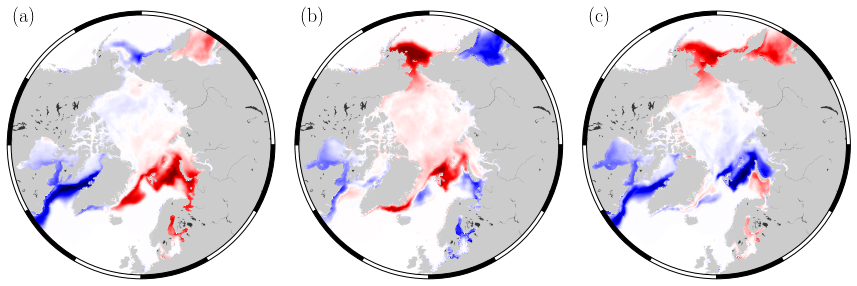

In [23]:
def PCA(data,weights,N=1,latlon=True,return_EOFs=False):
    dX = data.shape[0] ; dY = data.shape[1] ; dT = data.shape[2]
    if latlon:
        output_IDs = np.where((np.nanmax(np.abs(data),axis=2)>0))
        weights = np.sqrt(np.cos(np.radians(weights)))
    else:
        output_IDs = np.where(np.nanmax(np.abs(data),axis=2)>0)
        weights = np.sqrt(weights)
    
    data_weighted = np.multiply(data,weights[:,:,np.newaxis])
    X = data_weighted[output_IDs]
    U,S,V = np.linalg.svd(X,full_matrices=False)
    s = S**2
    print('Leading EOF(PC) =',100*s[0]/sum(s),'% of total variance')
    print('2nd Leading EOF(PC) =',100*s[1]/sum(s),'% of total variance')
    print('3rd Leading EOF(PC) =',100*s[2]/sum(s),'% of total variance')
    if return_EOFs:
        EOF = np.ones((dX,dY,N))*np.nan
        EOFs = U/(weights[output_IDs][:,np.newaxis])
        EOF[output_IDs] = EOFs[:,:N]
        return V.T[:,:N],EOF
    else:
        return V.T[:,:N]

with open('data/DJF_sic_network_1pct.pkl','rb') as f:
    SIC = pickle.load(f)

PCsEOFA,EOFs = PCA(SIC['DJF_dt'],SIC['psa'],N=3,latlon=False,return_EOFs=True)
EOFs[np.isclose(EOFs,0)] = np.nan
text = ['(a)','(b)','(c)']
plots = [EOFs[:,:,0]*100,EOFs[:,:,1]*100,EOFs[:,:,2]*100]
fig,ax = plt.subplots(1,3,figsize=(15,5))
for c in range(3):
    ax[c].text(.1e6,9e6,text[c])
    m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True,ax=ax[c])
    x,y = m(SIC['lon'],SIC['lat'])
    m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
    s = m.pcolormesh(x,y,plots[c],cmap='seismic',vmin=-.1,vmax=.1,rasterized=True)
    draw_meridians(m,ax[c],hemisphere='north')
plt.subplots_adjust(wspace=0.1)
plt.show()

# Figure 2.12: Clusters of winter sea ice concentration

Clusters generated using the Complex Networks code in the repository https://github.com/William-gregory/ComplexNetworks

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'contours', 'rasterized'


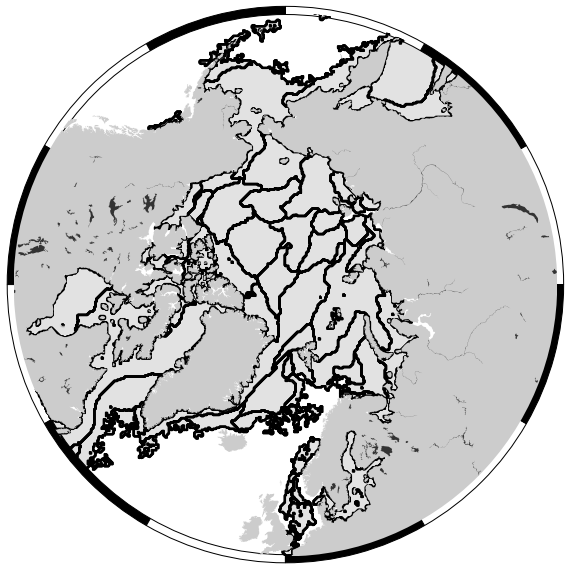

In [26]:
def strength(dataset,minL=50):
    k = 0
    strengthmap = np.zeros((448,304))*np.nan
    for node in dataset['nodes']:
        if len(dataset['nodes'][node]) > minL:
            for cell in dataset['nodes'][node]:
                strengthmap[cell[0],cell[1]] = dataset['strength'][node]
            k += 1
    return strengthmap

with open('data/DJF_sic_network_1pct.pkl','rb') as f:
    SIC = pickle.load(f)

fig,ax = plt.subplots(1,figsize=(10,10))
strengthmap = strength(SIC)
st = np.copy(strengthmap)
st[~np.isnan(st)] = 0.8
m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True,ax=ax)
m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2),zorder=100000)
m.pcolormesh(SIC['x'],SIC['y'],st,cmap='Greys_r',vmin=0,vmax=1,rasterized=True)
for area in (SIC['nodes']):
    if len(SIC['nodes'][area]) > 50:
        m.contour(SIC['x'],SIC['y'],strengthmap == SIC['strength'][area],colors=['k'],contours=1,rasterized=True)
draw_meridians(m,ax=ax,hemisphere='north',fontsize=0)
plt.show()



# Figure 2.14: Complex network of winter sea ice concentration

This piece of code requires the networkx python library

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


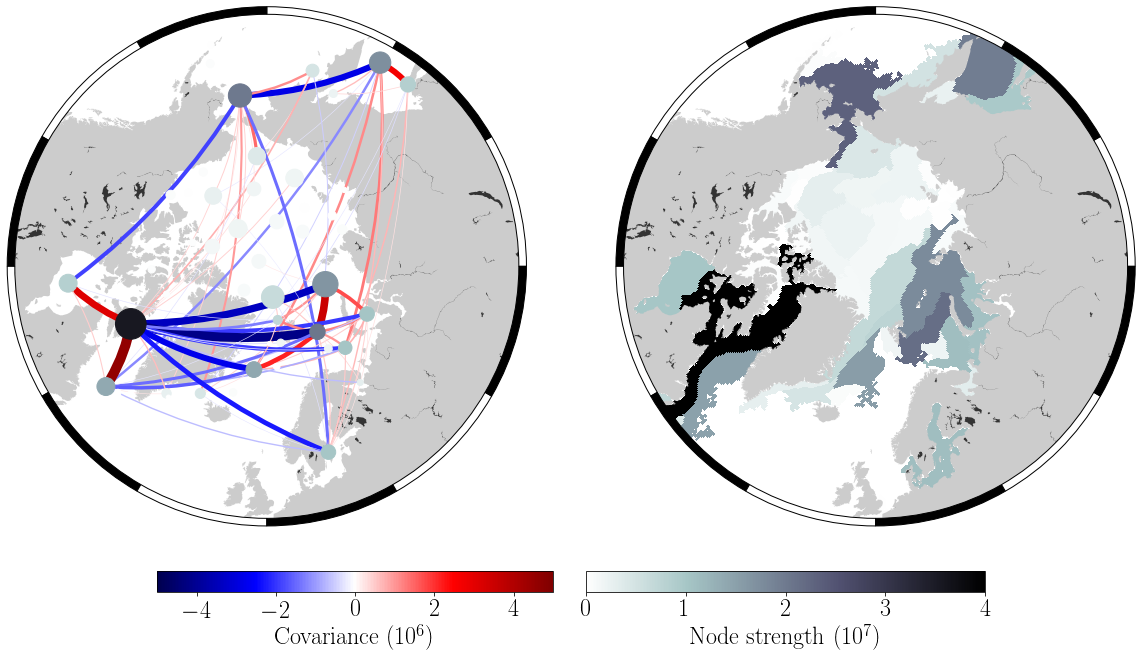

In [31]:
with open('data/DJF_sic_network_1pct.pkl','rb') as f:
    SIC = pickle.load(f)

def strength2():
    strengthmap = np.zeros((448,304))*np.nan
    for node in SIC['nodes']:
        if len(SIC['nodes'][node]) > 50:
            for cell in SIC['nodes'][node]:
                strengthmap[cell[0],cell[1]] = SIC['strength'][node]
    return strengthmap

def plot_graph():
    links = {}
    strength = {}
    alpha = 0.1
    graph = mx.DiGraph(directed=False)
    unavail = []
    unavail2 = []
    mapper1 = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-5e6, vmax=5e6), cmap=mpl.cm.seismic) 
    mapper2 = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4e7), cmap=mpl.cm.bone_r) 
    for node1a in SIC['nodes']:
        if len(SIC['nodes'][node1a])>50:
            node_size = 0
            for cell in SIC['nodes'][node1a]:
                node_size += SIC['psa'][cell[0],cell[1]]/2e3
            means = np.mean(SIC['nodes'][node1a],0)
            p = int(round(means[0])) ; q = int(round(means[1]))
            x1 = SIC['x'][p,q] ; y1 = SIC['y'][p,q]
            lon1,lat1 = m(x1,y1,inverse=True)
            if (node1a not in unavail) & (lat1 > 50):
                graph.add_node(node1a, pos=(x1,y1), color='black', size=node_size)
                unavail.append(node1a)
            X = SIC['anomalies'][node1a]
            SDx = np.std(X)
            for node1b in SIC['nodes']:
                if len(SIC['nodes'][node1b])>50:
                    node_size = 0
                    for cell in SIC['nodes'][node1b]:
                        node_size += SIC['psa'][cell[0],cell[1]]/2e3
                    means = np.mean(SIC['nodes'][node1b],0)
                    p = int(round(means[0])) ; q = int(round(means[1]))
                    x2 = SIC['x'][p,q] ; y2 = SIC['y'][p,q]
                    lon2,lat2 = m(x2,y2,inverse=True)
                    if (node1b not in unavail) & (lat2>50):
                        graph.add_node(node1b, pos=(x2,y2), color='black', size=node_size)
                        unavail.append(node1b)
                    Y = SIC['anomalies'][node1b]
                    SDy = np.std(Y)
                    R,P = stats.pearsonr(X,Y)
                    edge = R*(SDx*SDy)
                    nss = graph.nodes()
                    if (node1a != node1b) & (node1a in nss) & (node1b in nss):
                        links.setdefault(node1a, []).append(edge)
                    if (P/2 < alpha) & (node1a != node1b) & (node1a in nss) &\
                            (node1b in nss) & ([node1a,node1b] not in unavail2) & ([node1b,node1a] not in unavail2):
                        if edge > 0:
                            graph.add_weighted_edges_from([(node1a,node1b,edge)], color=mapper1.to_rgba(edge), style='solid') 
                        if edge < 0:
                            graph.add_weighted_edges_from([(node1a,node1b,abs(edge))], color=mapper1.to_rgba(edge), style='solid')
                        unavail2.append([node1a,node1b])
                        unavail2.append([node1b,node1a])
    for A in links:
        absolute = []  
        for i in links[A]:
            if ~np.isnan(i):
                absolute.append(abs(i))
        strength[A] = np.nansum(absolute)

    edges = graph.edges()
    nodes = graph.nodes()
    node_size = [mx.get_node_attributes(graph, 'size')[n] for n in nodes]
    node_color = [mapper2.to_rgba(strength[n]) for n in strength]
    edge_color = [graph[u][v]['color'] for u,v in edges]
    edge_style = [graph[u][v]['style'] for u,v in edges]
    weights = [graph[u][v]['weight'] for u,v in edges]
    minw = min(weights) ; maxw = max(weights)
    mw = max(abs(minw),abs(maxw))
    weights_scale = [(i/mw)*10 for i in weights]

    return [graph,node_size,node_color,edge_color,weights_scale]

m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True)
graph = plot_graph()
strengthmap = strength2()
st = np.copy(strengthmap)
st[~np.isnan(st)] = 0.8
weights = np.array(graph[4])
weights[weights<.5] = 0

fig,ax = plt.subplots(1,2,figsize=(20,10))
for c in range(2):
    if c == 0:
        m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True,ax=ax[c])
        m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
        draw_meridians(m,ax[c],hemisphere='north',fontsize=0)
        mx.draw(graph[0], pos=mx.get_node_attributes(graph[0], 'pos'), node_size=graph[1], node_color=graph[2],\
            edge_style='solid',edge_color=graph[3], width=list(weights), connectionstyle='arc3,rad=-0.1',arrowstyle='-',ax=ax[c],rasterized=True)
    else:
        m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True,ax=ax[c])
        m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
        s = m.pcolormesh(SIC['x'],SIC['y'],strengthmap/1e7,cmap='bone_r',vmin=0,vmax=4,rasterized=True)
        draw_meridians(m,ax=ax[c],hemisphere='north',fontsize=0)
plt.subplots_adjust(hspace=0,wspace=0.2)
p0 = ax[0].get_position().get_points().flatten()
p1 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0]+0.1, 0.05, (p1[2]-0.4)-(p0[0]+0.1), 0.03]) #xmin, ymin, xmax, thick
sm = plt.cm.ScalarMappable(cmap=mpl.cm.seismic, norm=plt.Normalize(vmin=-5, vmax=5))
cbar1 = fig.colorbar(sm, cax=ax_cbar,orientation='horizontal')
cbar1.solids.set_rasterized(True)
cbar1.set_label('Covariance (10$^6$)',fontsize=24)
cbar1.solids.set_edgecolor("face")
cbar1.ax.tick_params(labelsize=24)
ax_cbar = fig.add_axes([p1[0]-0.025, 0.05, (p1[2]-0.1)-(p1[0]-0.025), 0.03])
cbar2 = fig.colorbar(s, cax=ax_cbar,orientation='horizontal')
cbar2.solids.set_rasterized(True)
cbar2.set_label('Node strength (10$^7$)',fontsize=24)
cbar2.solids.set_edgecolor("face")
cbar2.ax.tick_params(labelsize=24)
plt.show()